# 04 Further Modelling

# Aim of the workbook




+ The aim of the workbook is to investigate whether i can re run some models focusing on finding key works rather than model accuracy if i may have some further insights


+ I will investigate the 'title' of the post and see if that provides a more condensed look at the post and key words.



---

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.metrics import confusion_matrix, roc_auc_score
import re
from sklearn.linear_model import LogisticRegression


%matplotlib inline

---

### Contents:
- [1.0 Data Import](#1.0-Data-Import-and-Cleaning)
- [2.0 Model Choice](#2.0-Model-Choice)
- [3.0 Pre-processing](#3.0-Pre-processing)
    - [3.1 Cleaning](#3.1-Cleaning)
    - [3.2 Create target class](#3.2-Create-target-class)
    - [3.3 Baseline values](#3.3-Baseline-values)
- [4.0 Modelling](#4.0-Modelling)
    - [4.1 Set features and Cross train split](#4.1-Set-features-and-Cross-train-split)
    - [4.2 TfidfVectorizer & Logistic Regressiong](#4.2-TfidfVectorizer-&-Logistic-Regression)
- [5.0 Production Model](#5.0-Production-Model)
- [6.0 Production Model Analysis](#6.0-Production-Model-Analysis)
- [7.0 Feature Extraction](#7.0-Feature-Extraction)    
- [8.0 Evaluation and Inferential meanings](#8.0-Evaluation-and-Inferential-meanings)
- [9.0 Summary](#9.0-Summary)

# 1.0 Data Import

#### Get Data

In [2]:
# Retrieve data
clean_posts = pd.read_csv('./data/processed_posts/clean_posts.csv', index_col = False)

In [3]:
# check shape is still correct
clean_posts.shape

(1204, 18)

In [4]:
# check columns are still correct for posts
clean_posts## 3.1 Clean

# Instantiate lemmatizer. (Same as above.)
lemmatizer = WordNetLemmatizer()

# Function to convert a raw text into clean data for the model

def clean_text(text):
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Stop words could be removed as a hyperparameter later but I think it
    # will be best to do it here and save on run time
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    # 4.Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemmatized_words))

---

# 2.0 Model Choice

+ I will use the same model for the reasone as previously discussed in the previous notebook.

+ I will use TfidfVectorizer becuase i want to find unique words to help with the data science problem at hand

+ I will force the model to search for groupings as well. So the n grams will be 2,3

---

# 3.0 Pre-processing

## 3.1 Cleaning

In [5]:
### Previously the 'titles' werent cleaned so I will do this now.

In [6]:
# Instantiate lemmatizer. (Same as above.)
lemmatizer = WordNetLemmatizer()

In [7]:
# Function to convert a raw text into clean data for the model

def clean_text(text):
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Stop words could be removed as a hyperparameter later but I think it
    # will be best to do it here and save on run time
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    # 4.Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemmatized_words))

In [8]:
# Check the before
print(clean_posts.iloc[1,3])

Amazon AWS Pro-Serve Data Scientist is it a good role?


In [9]:
print(clean_posts.iloc[35,3])

Why is Data Science considered a "science"


In [10]:
clean_posts['title'] = [clean_text(words) for words in clean_posts['title']]

In [11]:
# Check after
print(clean_posts.iloc[1,3])

amazon aws pro serve data scientist good role


In [12]:
print(clean_posts.iloc[35,3])

data science considered science


In [13]:
clean_posts.shape

(1204, 18)

---

In [14]:
clean_posts.loc[clean_posts['author'] == 'datascience-bot'].index

Int64Index([0, 60, 103, 156, 202, 233, 264, 297, 331, 349, 371, 401, 433, 525], dtype='int64')

In [15]:
clean_posts.drop(clean_posts.loc[clean_posts['author'] == 'datascience-bot'].index, inplace=True)

---

## 3.2 Create target class

+ Completed in previous workbook

## 3.3 Baseline values

In [16]:
clean_posts['target'].value_counts()

0    643
1    547
Name: target, dtype: int64

In [17]:
clean_posts['target'].value_counts(normalize=True)

0    0.540336
1    0.459664
Name: target, dtype: float64

###  Observations
Therefore if I said everything was in the analytics class then I would be correct 53% of the time.

---

# 4.0 Modelling

### 4.1 Set features and Cross train split

In [18]:
X = clean_posts['title'].tolist()
y = clean_posts['target']

In [19]:
# cross train split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(892, 298, 892, 298)

###  4.2 TfidfVectorizer & Logistic Regression

In [22]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [23]:
pipe_params = {
    'tvec__max_features': [100, 200, 300],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.3,0.4, 0.5, 0.6, 0.7],
    'tvec__ngram_range': [(2,3)],
    'tvec__stop_words':["english"],
    'lr__C': [1,0.1,0.01],
    'lr__max_iter': [1000]
}

In [24]:
%%time

gs_tf = GridSearchCV(pipe2, param_grid=pipe_params)
gs_tf.fit(X_train, y_train)
print(gs_tf.best_score_)

0.6950787772267906
CPU times: user 8.61 s, sys: 11.9 ms, total: 8.62 s
Wall time: 8.64 s


In [25]:
gs_tf.best_params_

{'lr__C': 1,
 'lr__max_iter': 1000,
 'tvec__max_df': 0.3,
 'tvec__max_features': 200,
 'tvec__min_df': 2,
 'tvec__ngram_range': (2, 3),
 'tvec__stop_words': 'english'}

In [26]:
gs_tf.score(X_train, y_train)

0.726457399103139

In [27]:
gs_tf.score(X_test, y_test)

0.6879194630872483

###  Observations


+ The model has lost some accuracy it is now at 0.71 down from 0.82


+ However this is sufficient to beat the benchmark and still deliver good predictions on which subreddit the post came from. 


+ 0.71 is an improvement on the benchmark of 0.53

---

# 5.0 Production Model

In [28]:
predictions = gs_tf.predict(X_test)

In [29]:
gs_tf.score(X_test, y_test)

0.6879194630872483

In [30]:
# best parameters for the model
gs_tf.best_params_

{'lr__C': 1,
 'lr__max_iter': 1000,
 'tvec__max_df': 0.3,
 'tvec__max_features': 200,
 'tvec__min_df': 2,
 'tvec__ngram_range': (2, 3),
 'tvec__stop_words': 'english'}

In [31]:
# 6.0 Production Model

predictions = gs_tf.predict(X_test)

gs_tf.score(X_test, y_test)

# best parameters for the model
gs_tf.best_params_

{'lr__C': 1,
 'lr__max_iter': 1000,
 'tvec__max_df': 0.3,
 'tvec__max_features': 200,
 'tvec__min_df': 2,
 'tvec__ngram_range': (2, 3),
 'tvec__stop_words': 'english'}

# 6.0 Production Model Analysis

In [32]:
# Get confusion matrix score
confusion_matrix(y_test, predictions)

array([[155,   6],
       [ 87,  50]])

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [34]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 155
False Positives: 6
False Negatives: 87
True Positives: 50


In [35]:
# Create a dataframe of true values of our test set and predicted probabilities based on our model.
pred_proba = [i[1] for i in gs_tf.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df;

In [36]:
type(pred_proba)

list

In [37]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

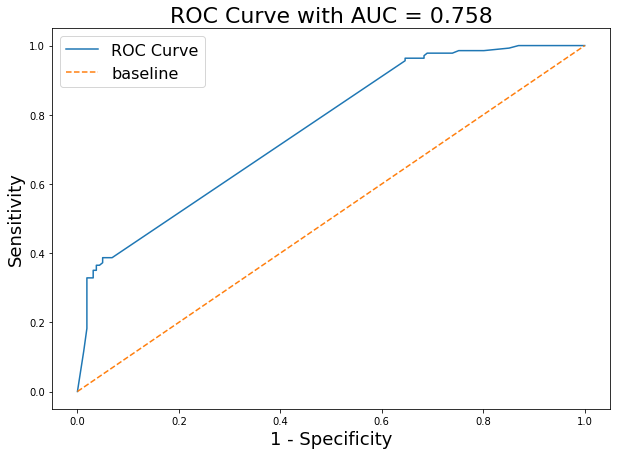

In [38]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## 7.0 Feature Extraction

In [39]:
## Get details of best model
gs_tvec_best = gs_tf.best_estimator_
gs_tvec_best

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.3, max_features=200,
                                 min_df=2, ngram_range=(2, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [40]:
# pull out the information about the step the pipeline took
named_steps = gs_tvec_best.named_steps
named_steps

{'tvec': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=0.3, max_features=200,
                 min_df=2, ngram_range=(2, 3), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words='english', strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 'lr': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [41]:
# check features match the models max_features
len(named_steps['tvec'].get_feature_names())

200

In [42]:
# store the features
feature_names = named_steps['tvec'].get_feature_names();

In [43]:
# Transforming our x_train data using our fit cvec. Currently stored as a sparse matrix 
# And converting the result to a DataFrame.
X_train_tvec = pd.DataFrame(named_steps['tvec'].transform(X_train).todense(),
                       columns=named_steps['tvec'].get_feature_names())

In [44]:
# Check sparse matrix has not been transformed
X_train_tvec.shape

(892, 200)

In [45]:
# Get the counts or the weighs of the model
word_counts = X_train_tvec.sum(axis=0)

In [46]:
X_train_tvec.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [47]:
# Lets look through some of the categories common words
common_words = []
cw_dict = {}
for i in range(2):
    word_count = X_train_tvec.loc[y_train==i].sum(axis=0)
    cw_dict[i] = word_count
    cw = word_count.sort_values(ascending = False).head(20)
    common_words.extend(cw.index)
    
analytics_tvec_df = pd.DataFrame(cw_dict[0])
ds_tvec_df = pd.DataFrame(cw_dict[1])

#### Get Analytics key words

In [48]:
analytics_tvec_df.reset_index(level=0, inplace=True)
analytics_tvec_df.rename(columns={0:'weight','index':"words"},inplace=True)

In [75]:
analysis_tvec_tp20 = analytics_tvec_df.sort_values('weight', ascending=False).head(20)
analysis_tvec_tp20

,words,weight
63,google analytics,39.796830
20,business analytics,14.845372
40,data analyst,12.336609
43,data analytics,7.641680
58,data studio,6.309744
67,google optimize,5.453000
74,interview question,4.241700
106,need help,4.226465
61,digital analytics,4.000000
197,web analytics,4.000000


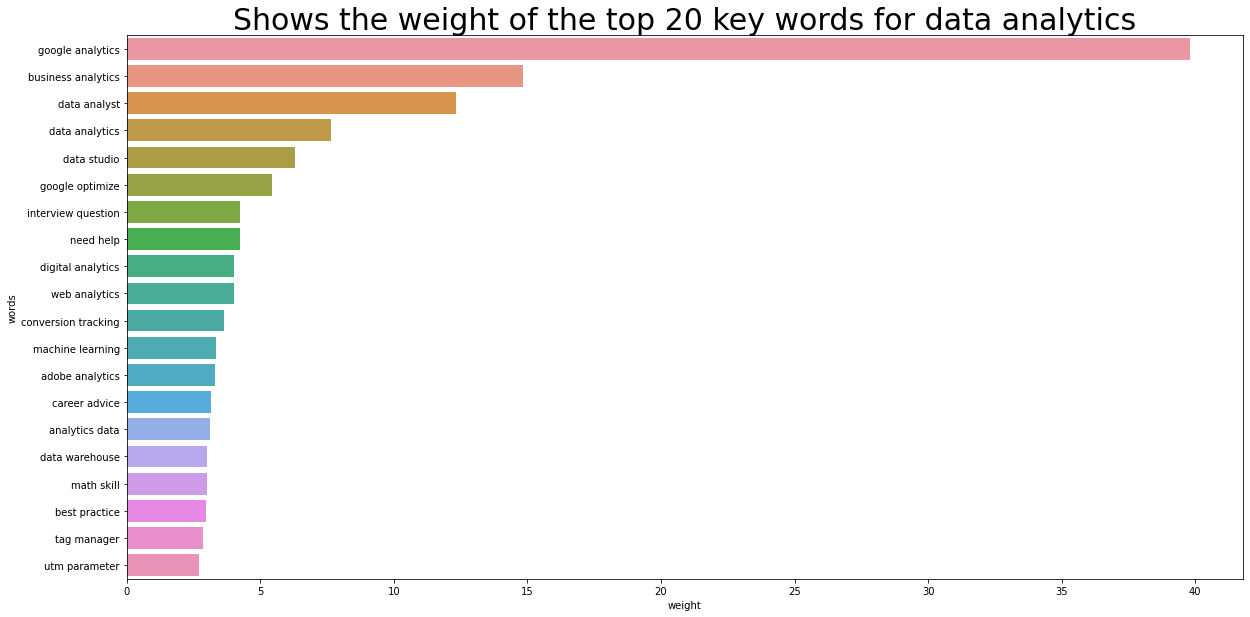

In [50]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(y="words", x="weight", data=analysis_tvec_tp20)
ax.set_title('Shows the weight of the top 20 key words for data analytics', fontdict={'fontsize':30});


#### Get Data Science key words

In [51]:
ds_tvec_df.reset_index(level=0, inplace=True)
ds_tvec_df.rename(columns={0:'weight','index':"words"},inplace=True)

In [76]:
ds_tvec_tp20 = ds_tvec_df.sort_values('weight', ascending=False).head(20)
ds_tvec_tp20

,words,weight
52,data science,59.549341
56,data scientist,31.888341
81,machine learning,10.397572
53,data science job,4.559469
148,science job,4.559469
112,open source,3.388370
49,data engineering,3.378427
59,data visualization,3.367282
154,science project,3.301672
54,data science project,3.301672


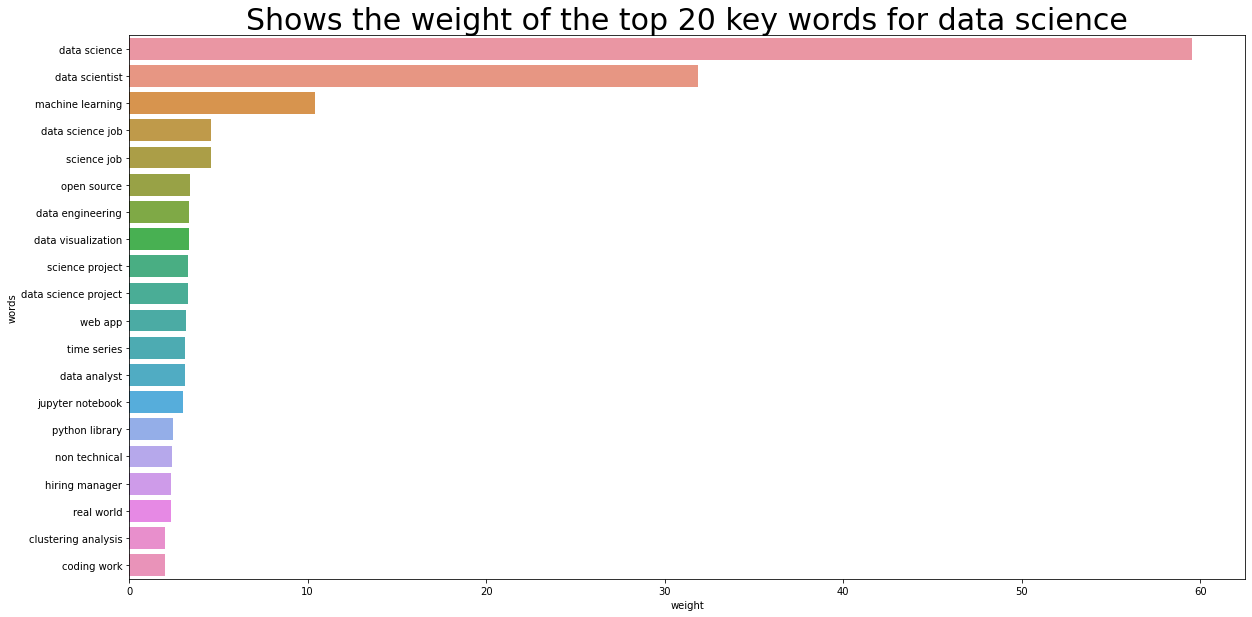

In [53]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(y="words", x="weight", data=ds_tvec_tp20)
ax.set_title('Shows the weight of the top 20 key words for data science', fontdict={'fontsize':30});

---

# 8.0 Inferential meanings

+ There are some great words but there are still some generic terms that need to be removed.


+ These words are useful for the reddits but not for extracting insights to answer the problem statemnts


+ e.g 'Job' is relevant what people want in reddit but it doesnt distinguish it so I will filter

In [54]:
# store the top 20
analytics_top_20 = analytics_tvec_df.sort_values('weight', ascending=False).head(20)

In [55]:
# ds words to filter
remove_a = ['interview question','career advice','best practice','need help','business analytic']

In [56]:
# filter
analytics_top = analytics_top_20.loc[~analytics_top_20['words'].isin(remove_a)]

In [57]:
# Print words
# print(f"|Word|Explanation|link|\n|---|---|---|")
# for word in analytics_top['words']:
#     print(f"|{word}|||")

### Analytics key words in the model

|Word|Explanation|link|
|---|---|---|
|google analytics|Lots of discussion and people asking for help. Google Analytics lets you measure your advertising ROI as well as track your Flash, video, and social networking sites and applications.|[10 reasons why you should use google analyitcs](https://medium.com/@dineshsem/10-good-reasons-why-you-should-use-google-analytics-699f10194834)|
|business analytics|A subset of analytics||
|data analyst|An analytics role||
|data analytics|Similar to Analytics||
|data studio| A free tool from Google that lets users make custom reports with data from Google’s marketing services and external sources. Data Studio is Google’s reporting solution for power users who want to go beyond the data and dashboards of Google Analytics. The data widgets in Data Studio are notable for their variety, customization options, live data and interactive controls (such as column sorting and table pagination). Data sources include Google products (Analytics, AdWords, Search Console, Sheets, YouTube, etc.), database connectors, file upload, and “community” connectors to popular marketing services |[Google Data Studio](https://www.marketingterms.com/dictionary/google-data-studio/#:~:text=Data%20Studio%20is%20Google's%20reporting,column%20sorting%20and%20table%20pagination)|
|google optimize|Optimize is natively integrated with Google Analytics, so you can quickly understand how your website can be improved.|[About Optimise](https://marketingplatform.google.com/about/optimize/)|
|digital analytics|Digital analytics encompasses the collection, measurement, analysis, visualisation and interpretation of digital data illustrating user behaviour on websites, mobile sites and mobile applications.|[About digital analytics](https://www.atinternet.com/en/glossary/digital-analytics-2/)|
|web analytics|Web analytics groups together the measurement, collection, analysis and presentation of data from the Internet in order to understand and optimise how websites are used. Web analytics lets you precisely study user behaviour on your websites (and mobile sites, and mobile applications, which is more largely called digital analytics).|[About web analytics](https://www.atinternet.com/en/glossary/web-analytics-2/)|
|conversion tracking|Conversion tracking is a free tool that shows you what happens after a customer interacts with your ads -- whether they purchased a product, signed up for your newsletter, called your business, or downloaded your app. When a customer completes an action that you've defined as valuable, these customer actions are called conversions. It is not just google but it is also a popular tool.|[About conversion tracking](https://support.google.com/google-ads/answer/1722022?hl=en)|
|machine learning|Machine learning is the science of getting computers to act without being explicitly programmed.|[about machine learning](https://www.coursera.org/learn/machine-learning)|
|adobe analytics|It is another web anlytics tool like google anlaytics. It approaches the problem slightly differently so good for analysts to know both|[What is adove analytics](https://www.seerinteractive.com/blog/a-beginners-guide-to-adobe-analytics/#what-is-adobe-analytics)|
|analytics data|General term but implies again the importance of data for analytics||
|math skill|Referencing math skill suggests it is a skill thats needed or is discussed in the community however key word doesnt imply what part odf mathematics is important ||
|data warehouse|A data warehouse is a system that pulls together data from many different sources within an organization for reporting and analysis. The reports created from complex queries within a data warehouse are used to make business decisions.|[Datawarehous guide](https://panoply.io/data-warehouse-guide/the-difference-between-a-database-and-a-data-warehouse/#:~:text=A%20data%20warehouse%20is%20a,used%20to%20make%20business%20decisions.)|
|tag manager|Google Tag Manager is a tag management system (TMS) that allows you to quickly and easily update measurement codes and related code fragments collectively known as tags on your website or mobile app.|[Tag Manager overview](https://support.google.com/tagmanager/answer/6102821?hl=en)|
|utm parameter|Urchin Tracking Module (UTM) parameters are five variants of URL parameters used by marketers to track the effectiveness of online marketing campaigns across traffic sources and publishing media.|[UTM parameters](https://en.wikipedia.org/wiki/UTM_parameters)|

In [58]:
# Data Science driving the model
ds_top20 = ds_tvec_df.sort_values('weight', ascending=False).head(20)

In [59]:
# ds words to filter
remove = ['data science','data scientist','data science job','science job']

In [60]:
ds_top = ds_top20.loc[~ds_top20['words'].isin(remove)]


In [61]:
# print(f"|Word|Explanation|link|\n|---|---|---|")
# for word in ds_top['words']:
#     print(f"|{word}|||")

### Data Science key words in the model


|Word|Explanation|link|
|---|---|---|
|machine learning|Machine learning is the science of getting computers to act without being explicitly programmed.|[about machine learning](https://www.coursera.org/learn/machine-learning)|
|time series|Time Series analysis is “an ordered sequence of values of a variable at equally spaced time intervals.” It is used to understand the determining factors and structure behind the observed data, choose a model to forecast, thereby leading to better decision making. It is used in industries such as stock market analysis, Economic forecasting, sales forecasting etc|[About time series analysis](https://www.researchoptimus.com/article/what-is-time-series-analysis.php)|
|data engineering|A data engineer builds a robust, fault-tolerant data pipeline that cleans, transforms, and aggregates unorganized and messy data into databases or datasources. Data engineers are typically software engineers by trade. Instead of data analysis, data engineers are responsible for compiling and installing database systems, writing complex queries, scaling to multiple machines, and putting disaster recovery systems into place. Data engineers essentially lay the groundwork for a data analyst or data scientist to easily retrieve the needed data for their evaluations and experiments.|[Role definition](https://blog.udacity.com/2014/12/data-analyst-vs-data-scientist-vs-data-engineer.html)|
|jupyter notebook| The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, data visualization, machine learning etc.|[about jupyter notebook](https://jupyter.org/)|
|open source|Open source software is software with source code that anyone can inspect, modify, and enhance. It is a shame the key word doesnt reveal anything more specific about which open source project or code they are discussing|[About open source](https://opensource.com/resources/what-open-source)|
|data science project/science project|Refers to a piece of work a data scientist is doing. It is popular among new data scientist to complete these as a way of growing there portfolio||
|data visualization|Data visualization is important for a Data Scientist and it one of the most useful professional skills to develop. It is important to use the right graphs, use labels, and to be able to make the data easily understandable.|[Visualisation info](https://towardsdatascience.com/top-subreddits-every-data-scientist-should-join-c98a0bf34c03)|
|web app|A lot of people are discusing how to build a web app|[Building web apps](https://towardsdatascience.com/building-a-web-application-to-deploy-machine-learning-models-e224269c1331)|
|data analyst|Data analyst role - hints at the intersection of the two roles||
|python library|Coding language synonomous with Data Science and Jupyter notebooks|[Python Library](https://docs.python.org/3/library/)|
|non technical| A lot of people are asking for non technical books for explanations||
|real world|Alot of discussion around getting real world data projects for experience. Often talk of real world in context to how theory needs to be applied in this context. Also what actually happens||
|clustering analysis|Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters).|[Cluster Analysis](https://en.wikipedia.org/wiki/Cluster_analysis#:~:text=Cluster%20analysis%20or%20clustering%20is,in%20other%20groups%20(clusters).)|
|coding work| Original posts do not show a trend realted to data science||

### Learnings from the model

There is a difference in language between the data analyst and the key words are different so this shows this.

Data Science

+ Key skill topics
    + Python
    + Jupyter Notebooks
    + Web App developments - How to deploy machine learning app 
    + Machine learning
    + Data Visualisation
    

+ Key General topics
    + Data Engineering
    + Time series analysis
    + Web app development - people discussing its importance


Analytics

+ Key skill topics
    + Google analytics
    + Adobe anayltics
    + Data Warehouse
    + Google Optimise
    + Machine learning
    

+ Key General topics
    + Business Analyics
    + Math skills necessity for data analysts

### What do the words infer about the data science and analytics?

#### Data science words:

+ They are generally more technical and refer to building things. 
     + Data Engineers for example will focus on building data pipelines which data scsinetist can use. There is disussion in the forum of doing this themselves.
     + Web apps are discussed with the intention of deploying machine learning models on the cloud for people to use. Easier to share than sending jupyter notebooks.
     + Data visualisation is a big part of data science and building or creating your own is a discussed and help sort on the reddit forum
     + Time series analysis is about analysing a constant stream of data and trying to predict the future such as stock market analysis. Again another technical role.
     + Techncal skills discussed are python and juypter notebook which is popuplar in this community.
     
     
#### Analytics  words:

+ They are generally more web based focused and using tools to extract data to drive business behaviours. 
     + Google analytics suite of products is popular. So analysis of web traffic and customers and trying to increase sales conversion rates is important.
     + Data studio is another google tools which allows custom dashboards. Its very customizable and allows data to be manipulated easily.
     + Data warehousing is a more traditional data analysis tool for storing database records over time.


---

# 9.0 Summary

Production Model

+ The previous best model was over 82% accurate

    + It did also deliver key words
    
    + However they were not as specific or useful as the model above


+ If I had to pick one model it would be this one

    + It offers more insights into the phrases that drive the model
    
    + It loses accuracy compared to the previous best model however it is still over 70% accurate
    
    + Its ROC AUC score is lower at 0.774 compared to 0.869
    
    + It still significantly beats the benchmar: 0.71 compared to 0.53
    